In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import math
import random
import copy
from collections import namedtuple, deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# from ddpg_agent import Agent
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')
#for 20 agents:
# env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [3]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=1, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first 
            hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=1, fcs1_units=400, fc2_units=300, atoms=51):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, atoms)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x),dim=1)

NameError: name 'nn' is not defined

In [7]:
torch.distributions.Normal(torch.tensor([0,0,0,0]).float(), torch.tensor([1,1,1,1]).float()).sample()

tensor([-2.5146,  0.5734, -0.2548,  1.0413])

In [3]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 1e-5 
if num_agents==1: # L2 weight decay
    UPDATE_EVERY = 400
    LEARN_NUM = 200   
else:
    UPDATE_EVERY = 20
    LEARN_NUM = 10
# number of learning passes
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter
# OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter

EPSILON = 1.0           # explore->exploit noise process added to act step
EPSILON_DECAY = 1e-6 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, gamma= GAMMA,
                 tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
                 update_every=UPDATE_EVERY, learn_num=LEARN_NUM, eps=EPSILON, eps_decay=EPSILON_DECAY,rollout_length=5,
                 atoms=51, V_max=7, V_min=0, soft_update=True, hard_update=350, random_seed=1, eps_gauss=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        #hyperparams
        self.batch_size=batch_size
        self.batch_size=batch_size
        self.buffer_size=buffer_size
        self.gamma=gamma
        self.tau=tau
        self.lr_actor=lr_actor
        self.lr_critic=lr_critic
        self.weight_decay=weight_decay
        #the atoms
        self.num_atoms=atoms
        self.V_max=V_max
        self.V_min=V_min
        self.delta=(self.V_max-self.V_min)/(self.num_atoms-1)
        self.atoms=torch.tensor([self.delta*i+self.V_min for i in range(self.num_atoms)])
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, atoms=self.num_atoms).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, atoms=self.num_atoms).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
         
        # Replay memory
        self.rollout_length=rollout_length
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, random_seed, self.rollout_length)
        
        #update_every
        self.update_every=update_every
        self.learn_num=learn_num
        self.soft=soft_update
        self.t_step = 0
        self.t_hard=0
        self.hard= hard_update
        
        #gaussian noise
        self.eps=eps
        self.eps_decay=eps_decay
        self.eps_gauss=eps_gauss
        self.means=torch.tensor([0,0,0,0]).float()
        self.stds=torch.tensor([1,1,1,1]).float()
        self.gauss=torch.distributions.Normal(self.means, self.stds)
        #counter
        self.counter_step=0
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        # Learn, if enough samples are available in memory
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                #either put a for loop here to update many times for a single time_step
                for _ in range(self.learn_num):
                    experiences = self.memory.sample()
                    self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        self.t_step = (self.t_step + 1) % self.update_every
        if self.soft==False:
            self.t_hard = (self.t_hard + 1) % self.hard
        if add_noise:
            if self.eps_gauss:
                action += self.gauss.sample()*self.eps
            else:
                action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
    
    def project_dist(self,dist,returns_tmp,gamma):
        proj_atoms=torch.zeros((self.num_atoms,self.batch_size)).to(device)
        dist=dist.permute([1,0]) #num_atoms*B
#         print("dist.shape:",dist.shape)
#         print("dist",dist)
        for i in range(self.num_atoms):
            #size B 
            to_proj=returns_tmp.squeeze()+gamma**self.rollout_length * self.atoms[i]
#             print("to_proj.shape:",to_proj.shape)
            proj_atoms[i]=torch.clamp(torch.tensor(to_proj),self.V_min,self.V_max)
#         print("proj_atoms:",proj_atoms)    
#         new_dist=torch.zeros_like(dist).to(device)
        #immediate implementation of the eq (7) in Distributional paper
#         for i in range(self.num_atoms):
#             new_dist[i]=(torch.clamp(1-torch.abs(proj_atoms-self.atoms[i])/self.delta,0,1)*dist).sum(dim=0)
#         print("previous new_dist:",new_dist)
        #implementation of algorithm 1 
        #size 1* num_atoms * num_atoms*B = 1*B
#         prev_new_dist=new_dist.clone()
        new_dist=torch.zeros_like(dist).to(device)
        #here below instead of dist[j] it uses actually this best_action_value below in the algorithm!
#         best_action_value=self.atoms.to(device).matmul(dist)
#         print("best_action_value.shape:",best_action_value.shape)
#         print("best_action_value:",best_action_value)
        for j in range(self.num_atoms):    
            bj=torch.zeros(self.batch_size).to(device)
            bj=(proj_atoms[j]-self.V_min)/self.delta
            #shape B
            u=torch.ceil(bj).long()
            l=torch.floor(bj).long()
            new_dist[l]+=dist[j]*(u.float()-bj)
            new_dist[u]+=dist[j]*(bj-l.float())
#         print("new new_dist.shape:",new_dist.shape)
#         print("new new_dist:",new_dist)
#         print("difference:", prev_new_dist-new_dist)
        return new_dist.permute([1,0])
        
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        with torch.no_grad():            
            actions_next = self.actor_target(next_states[self.rollout_length-1])
            Z_target_next = self.critic_target(next_states[self.rollout_length-1], actions_next)
#             print("Z_target_next.shape:",Z_target_next.shape)
#             print("Z_target_next:",Z_target_next)
            # Compute returns_tmp size B*1
#             print("rewards:",rewards)
            returns_tmp = np.array([rewards[i]*(gamma**i) for i in range(self.rollout_length)]).sum(axis=0)
#             print("returns_tmp.shape:",returns_tmp.shape)
#             print("returns_tmp:",returns_tmp)
            #dimension B*self.num_atoms
            Y_target = returns_tmp + (gamma**self.rollout_length * Z_target_next * (1 - dones[self.rollout_length-1]))
#             print("Y_target.shape:",Y_target.shape)
#             print("Y_target:",Y_target)
            Y_target = self.project_dist(Y_target,returns_tmp,gamma)
        
#         print("Y_target.shape:",Y_target.shape)
#         print("Y_target:",Y_target)
#         Y_target=Y_target.detach()
        # Compute critic loss
        #shouldn't we just use the hubert loss again?
        self.critic_local.train()
        Z_expected = self.critic_local(states[0], actions[0])
#         print("Z_expected.shape:",Z_expected.shape)
#         print("Z_expected:",Z_expected)
        #to perform prioritized here just add weight=BUFFER_SIZE/p with p the probability
        critic_loss = -(Y_target*torch.log(Z_expected+1e-10)).sum(dim=1).mean()
        
#         print("critic_loss=:",critic_loss)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states[0])
        #basically it's about maximizing the Q(s,action_provided_by_actor) hence the negative sign, B*atoms matmul atoms*1
#         self.critic_local.eval() # i am not sure about that ... 
        actor_loss = -self.critic_local(states[0], actions_pred).matmul(self.atoms.to(device)).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
#         print("actor_loss:",actor_loss)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        
        if self.soft_update:
            self.soft_update(self.critic_local, self.critic_target, self.tau)
            self.soft_update(self.actor_local, self.actor_target, self.tau)
        elif self.t_hard==0:
            self.hard_update(self.critic_local, self.critic_target)
            self.hard_update(self.actor_local, self.actor_target)
#         print(self.counter_step)
        self.counter_step+=1
        if self.eps_gauss:
            self.eps=self.eps-self.eps_decay
            

    def soft_update(self, local_model, target_model, tau):
        # we might want to implement a hard update instead of soft as done in the paper
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    def hard_update(self,local_model,target_model):
        target_model.load_state_dict(local_model.state_dict())

            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.04, sigma=0.02):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample. here dt = 1"""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.gauss(0,1) for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, rollout_length):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.rollout_length=rollout_length
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        starts = random.sample(list(range(len(self.memory)-self.rollout_length)), k=self.batch_size)
        states,actions,rewards,next_states,dones=(list() for _ in range(5))
        for i in range(self.rollout_length):
            experiences= [self.memory[start+i] for start in starts]
            states.append(torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device))
            actions.append(torch.from_numpy(np.vstack([e.action for e in experiences  if e is not None])).float().to(device))
            rewards.append(torch.from_numpy(np.vstack([e.reward for e in experiences  if e is not None])).float().to(device))
            next_states.append(torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device))
            dones.append(torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device))

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128      # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4        # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 1e-5 
if num_agents==1: # L2 weight decay
    UPDATE_EVERY = 400
    LEARN_NUM = 400   
else:
    UPDATE_EVERY = 20
    LEARN_NUM = 10
# number of learning passes
# OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter
# OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter

EPSILON = 1.0           # explore->exploit noise process added to act step
EPSILON_DECAY = 1e-6 

agent = Agent(state_size=state_size, action_size=action_size,batch_size=128,
    buffer_size=1000000,
    gamma=0.99,
    tau=0.001,
    lr_actor=0.0001,
    lr_critic=0.001,
    weight_decay=1e-5,
    update_every=20,
    learn_num=10,
    eps=1.0,
    eps_decay=1e-06,
    rollout_length=5,
    atoms=51,
    V_max=0.5,
    V_min=0,
    soft_update=False,
    hard_update=350,
    random_seed=1,
    eps_gauss=False)

In [6]:
import time
stats=f''
mean_scores,min_scores,max_scores,moving_avgs=([] for _ in range(4))
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth',eps=EPSILON,eps_decay=EPSILON_DECAY,eps_gauss=False):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    global mean_scores,min_scores,max_scores,moving_avgs,stats # list of mean scores from each episode
    stats+=f'{agent.batch_size}{agent.buffer_size}{agent.gamma}{agent.tau}{agent.lr_actor}{agent.lr_critic}{agent.weight_decay}'
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
                                  # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset() #so the noise gets close to zero in some time_steps... but how many really?! oh my god ... 
        agent.eps_gauss=eps_gauss
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations
            # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)             
            states = next_states
            scores += rewards
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                stats+=f'solved{i_episode}'
                torch.save(agent.actor_local.state_dict(), stats+actor_path)
                torch.save(agent.critic_local.state_dict(), stats+critic_path)
                np.savetxt(stats+f'mean',mean_scores)
                np.savetxt(stats+f'min',min_scores)
                np.savetxt(stats+f'max',max_scores)
                np.savetxt(stats+f'avg',moving_avgs)
            break
            
    return mean_scores,min_scores,max_scores,moving_avgs,stats
mean_scores,min_scores,max_scores,moving_avgs,stats = ddpg()

c:\users\shoki\anaconda3\envs\ml-agents\lib\site-packages\ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 1 (945 sec)  -- 	Min: 0.0	Max: 2.0	Mean: 0.7	Mov. Avg: 0.7
Episode 2 (943 sec)  -- 	Min: 0.0	Max: 1.5	Mean: 0.8	Mov. Avg: 0.7
Episode 3 (956 sec)  -- 	Min: 0.2	Max: 2.2	Mean: 0.8	Mov. Avg: 0.8
Episode 4 (1015 sec)  -- 	Min: 0.0	Max: 2.4	Mean: 0.8	Mov. Avg: 0.8
Episode 5 (1020 sec)  -- 	Min: 0.3	Max: 2.0	Mean: 0.9	Mov. Avg: 0.8
Episode 6 (1027 sec)  -- 	Min: 0.0	Max: 1.7	Mean: 0.8	Mov. Avg: 0.8
Episode 7 (1040 sec)  -- 	Min: 0.3	Max: 2.3	Mean: 1.0	Mov. Avg: 0.8
Episode 8 (1050 sec)  -- 	Min: 0.2	Max: 1.5	Mean: 0.7	Mov. Avg: 0.8
Episode 9 (1062 sec)  -- 	Min: 0.3	Max: 1.9	Mean: 0.8	Mov. Avg: 0.8
Episode 10 (1072 sec)  -- 	Min: 0.4	Max: 3.5	Mean: 1.2	Mov. Avg: 0.9
Episode 11 (1082 sec)  -- 	Min: 0.2	Max: 1.9	Mean: 0.9	Mov. Avg: 0.9
Episode 12 (1089 sec)  -- 	Min: 0.1	Max: 1.9	Mean: 0.8	Mov. Avg: 0.9
Episode 13 (1101 sec)  -- 	Min: 0.0	Max: 1.9	Mean: 0.7	Mov. Avg: 0.9
Episode 14 (1114 sec)  -- 	Min: 0.0	Max: 2.0	Mean: 0.8	Mov. Avg: 0.8
Episode 15 (1125 sec)  -- 	Min: 0.1	Max: 1.6	M

KeyboardInterrupt: 

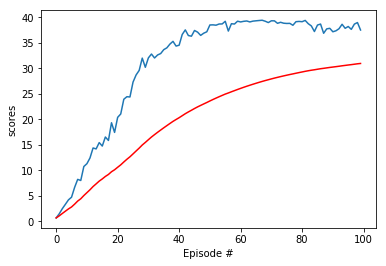

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
# avgs=np.array([np.array(scores[max(i-100,0):i]).mean() for i in range(1,len(scores)+1)])
plt.plot(np.arange(len(avgs)), avgs, c='r')
plt.ylabel('scores')
plt.xlabel('Episode #')
plt.show()

In [15]:
agent.actor_local.load_state_dict(torch.load(f'actor_ckpt_1e61280.991e-31e-31e-302010sigma0.02theta0.04seed1.pth',map_location=device))
agent.critic_local.load_state_dict(torch.load(f'critic_ckpt_1e61280.991e-31e-31e-302010sigma0.02theta0.04seed1.pth',map_location=device))

In [28]:
# Watch it play
episodes=1
for i in range(episodes):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)  
    counter=0# initialize the score (for each agent)
    for _ in range(1002):  
        actions = agent.act(states) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states
        counter+=1# roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
print('Total score (averaged over agents) this episode: {} and counter {}'.format(np.mean(scores),counter))

Total score (averaged over agents) this episode: 38.354999142698944 and counter 1001


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import deque 

scores=[]# list containing scores from each episode
avgs=[]

def ddpg_train(agent,env,brain_name,n_episodes=400, max_t=2000,target_score=30,eps=EPSILON,eps_decay=EPSILON_DECAY):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (for reacher environment, an episode is 1001 timesteps)
        target_score: stopping point for training and saving checkpoint
    Returns
    ======
        scores,avgs: The history of scores and the history of last 100 score averages
        Also saves the checkpoint and the scores array (filepath `stats` given by agent (hyper)parameters)
    """
    
    stats=f'{testrun}'
#     stats=f"{agent.buffer_size}{agent.batch_size}{agent.gamma}{agent.tau}{agent.lr}{agent.update_every}"
#     stats+=f"{agent.hidden_layer}{agent.hidden_layer_size}{agent.seed}{agent.network}{agent.time_aware}"
#     if agent.network=="mhq_dfq": stats+=f"{agent.mh_size}{agent.hidden_layer_d}"
#     stats+=f"{eps_start}{eps_end}{eps_decay}"  #save_path a la tensorboard! 
    global scores# list containing scores from each episode
    global avgs# list containing average of last 100 scores from each episode
    scores=[]
    avgs=[]
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]  
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            eps=min(eps-eps_decay,0.001)
            if done:
                break       
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), f"{stats+str(i_episode)}actor_local.ph")
            torch.save(agent.critic_local.state_dict(), f"{stats+str(i_episode)}critic_local.ph")
            torch.save(agent.actor_target.state_dict(), f"{stats+str(i_episode)}actor_target.ph")
            torch.save(agent.critic_target.state_dict(), f"{stats+str(i_episode)}critic_target.ph")
            np.savetxt(f'{stats+str(i_episode)}scores',np.array(scores))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            avgs=np.array([np.array(scores[max(i-100,0):i]).mean() for i in range(1,len(scores)+1)])
            plt.plot(np.arange(len(avgs)), avgs, c='r')
            plt.ylabel('scores')
            plt.xlabel('Episode #')
            plt.show()
            break
    return scores,avgs
scores,avgs=ddpg_train(agent,env,brain_name)

Episode 9	Average Score: 0.07

KeyboardInterrupt: 

In [16]:
# agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

state = env.reset()
for t in range(200):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

TypeError: expected np.ndarray (got dict)

### 6. Explore

In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster than this benchmark implementation.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task!
- Write your own DDPG implementation.  Use this code as reference only when needed -- try as much as you can to write your own algorithm from scratch.
- You may also like to implement prioritized experience replay, to see if it speeds learning.  
- The current implementation adds Ornsetein-Uhlenbeck noise to the action space.  However, it has [been shown](https://blog.openai.com/better-exploration-with-parameter-noise/) that adding noise to the parameters of the neural network policy can improve performance.  Make this change to the code, to verify it for yourself!
- Write a blog post explaining the intuition behind the DDPG algorithm and demonstrating how to use it to solve an RL environment of your choosing.  